In [1]:
import networkx as nx
import itertools

import pandas as pd
import pandas
from pandas import DataFrame, Series
import gc

import matplotlib.pyplot as plt
import numpy

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

In [3]:
all_male_dist_twice = pandas.read_hdf('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/male_dist_admix_masked_stores/7/CHB/male_dist_data_chr7_100kb_CHB_twice.hdf')

# remove unused columns
to_keep = ['indiv_1', 'indiv_2', 'start', 'end', 'dist', 'dist_af', 
           'region_1', 'region_2', 'pop_1', 'region_label_1', 'region_id_1']
to_drop = [x for x in all_male_dist_twice.columns if x not in to_keep]
all_male_dist_twice.drop(to_drop, axis=1, inplace=True)

gc.collect()

214

In [4]:
all_male_dist_twice.head()

,dist,dist_af,end,indiv_1,indiv_2,start
0,NaN,NaN,100000,NA18530,NA18603,0
1,NaN,NaN,100000,NA18530,NA18637,0
2,NaN,NaN,100000,NA18530,NA18635,0
3,NaN,NaN,100000,NA18530,NA18563,0
4,NaN,NaN,100000,NA18530,NA18747,0


In [5]:
numpy.mean(Series([1,2,3, numpy.nan]))

2.0

In [6]:
Series([]).isin([])

Series([], dtype: bool)

In [68]:
def call_rolling_windows(df, pwdist_cutoff, min_sweep_clade_size):
    """

    """

    # build data frame to return
    cols = ['indiv_1', 'start', 'end', 'off']
    result_df = pandas.DataFrame(list(df.groupby(cols).groups.keys()), columns=cols)

    # Get mean dist between pairs in the 500kb window (make mean nan if any 100kb is nan):
    win_dist = df.groupby(['indiv_1', 'indiv_2']).dist.agg(numpy.mean)
    
    # Build graph
    graph = nx.Graph()
    for tup in win_dist[win_dist <= pwdist_cutoff].reset_index().itertuples():
        graph.add_edge(tup.indiv_1, tup.indiv_2)
        
    cliques = sorted(nx.algorithms.clique.find_cliques(graph), key=len, reverse=True)

    if cliques:
        largest_clique = cliques[0]
    else:
        largest_clique = []

    # find swept
    result_df['called'] = False
    result_df['mean_clade_dist'] = numpy.nan
    result_df['clade_size'] = numpy.nan
    
    for clique in cliques:

        if len(clique) >= min_sweep_clade_size:
            # get indiv pairs. (in just one orientation). that is fine because df has both orientations

            called = result_df.indiv_1.isin(clique)
            result_df['called'] = called | result_df.called # do not make it False if it is already True                        
            # clade_size is the size of the clique
            result_df.loc[called, 'clade_size'] = len(clique) 

            # mean_clade_dist is the mean dist of the clique
            indiv_pairs = list(itertools.combinations(sorted(clique), 2))
            result_df.loc[called, 'mean_clade_dist'] = win_dist.loc[indiv_pairs].mean()
            
        else:
            # cliques are only getting smaller
            break
                
                
    if 'dist_af' in df.columns:
        
        # Get mean dist between pairs in the 500kb window (make mean nan if any 100kb is nan):
        win_dist = df.groupby(['indiv_1', 'indiv_2']).dist_af.agg(numpy.mean)

        # Build graph
        graph = nx.Graph()
        for tup in win_dist[win_dist <= pwdist_cutoff].reset_index().itertuples():
            graph.add_edge(tup.indiv_1, tup.indiv_2)

        cliques = sorted(nx.algorithms.clique.find_cliques(graph), key=len, reverse=True)

        if cliques:
            largest_clique = cliques[0]
        else:
            largest_clique = []

        # find swept
        result_df['called_af'] = False
        result_df['mean_clade_dist_af'] = numpy.nan
        result_df['clade_size_af'] = numpy.nan

        for clique in cliques:

            if len(clique) >= min_sweep_clade_size:
                # get indiv pairs. (in just one orientation). that is fine because df has both orientations

                called = result_df.indiv_1.isin(clique)
                result_df['called_af'] = called | result_df.called_af # do not make it False if it is already True                        
                # clade_size is the size of the clique
                result_df.loc[called, 'clade_size_af'] = len(clique) 

                # mean_clade_dist is the mean dist of the clique
                indiv_pairs = list(itertools.combinations(sorted(clique), 2))
                result_df.loc[called, 'mean_clade_dist_af'] = win_dist.loc[indiv_pairs].mean()

            else:
                # cliques are only getting smaller
                break
                
    return result_df



offset = 100000
nr_wins = 5
offsets = [x * offset for x in range(nr_wins)]
window_size = 500000

lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    print(off)
    groups = (all_male_dist_twice
                .assign(off=off, # keep offset
                        roll_win = lambda df: (off + df.start) // window_size) # label for rolling 500kb window
                .groupby(['roll_win', 'off'], as_index=False)
                )

    lst.append(groups.apply(call_rolling_windows, 0.0005, 10))


0
100000
200000
300000
400000


In [54]:
df = pandas.concat(lst)

In [55]:
gr = df.loc[(df.indiv_1 == 'NA18530') & (df.start == 3700000)]
gr

indiv_1    start      end     off  called  mean_clade_dist  clade_size
7 2  NA18530  3700000  3800000       0   False              NaN         NaN
  3  NA18530  3700000  3800000  100000    True         0.000212        10.0
  4  NA18530  3700000  3800000  200000    True         0.000129        10.0
8 0  NA18530  3700000  3800000  300000    True         0.000255        18.0
  1  NA18530  3700000  3800000  400000   False              NaN         NaN

In [56]:
max_clade_size = gr.clade_size.max()
(gr.groupby('off')
 .filter(lambda df: (df.clade_size == max_clade_size).all() and df.called.all())
)
#.mean_clade_dist.mean()

,,indiv_1,start,end,off,called,mean_clade_dist,clade_size
8,0,NA18530,3700000,3800000,300000,True,0.000255,18.0


In [57]:
df.called.sum()/len(df)

0.4281556581859919

In [58]:
(~numpy.isnan(df.mean_clade_dist)).sum()

156675

In [59]:
df.head()

indiv_1   start     end  off  called  mean_clade_dist  clade_size
0 0  NA18530       0  100000    0   False              NaN         NaN
  1  NA18530  100000  200000    0   False              NaN         NaN
  2  NA18530  200000  300000    0   False              NaN         NaN
  3  NA18530  300000  400000    0   False              NaN         NaN
  4  NA18530  400000  500000    0   False              NaN         NaN

In [60]:
df.called.sum()

156675

In [61]:
df[df.called].clade_size.describe()

count    156675.000000
mean         16.228996
std           8.477325
min          10.000000
25%          10.000000
50%          12.000000
75%          19.000000
max          46.000000
Name: clade_size, dtype: float64

In [62]:
def call_swept(df):
    """
    Takes a df with all rolling window data for an indivisual for one 100kb window.
    Call each 100kb window as sweept if any overlapping rolling window is called as swept.
    Compute clade size and mean clade dist as from the rolling window with the largest clade size.
    """
    max_clade_size = df.clade_size.max()
    largest_clade_offsets = (df.groupby('off')
                             .filter(lambda df: (df.clade_size == max_clade_size).all() and df.called.all())
                            )
    if 'dist_af' in df.columns:
        max_clade_size_af = df.clade_size_af.max()
        largest_clade_offsets_af = (df.groupby('off')
                                .filter(lambda df: (df.clade_size_af == max_clade_size_af).all() and df.called_af.all())
                                )
        return DataFrame(dict(called=[df.called.any()], 
                            clade_size=[max_clade_size],
                            clade_mean_dist=[largest_clade_offsets.mean_clade_dist.mean()], # actually mean over identical numbers
                            called_af=[df.called_af.any()], 
                            clade_size_af=[max_clade_size_af],
                            clade_mean_dist_af=[largest_clade_offsets_af.mean_clade_dist.mean()])) # actually mean over identical numbers
    else:
        return DataFrame(dict(called=[df.called.any()], 
                            clade_size=[max_clade_size],
                            clade_mean_dist=[largest_clade_offsets.mean_clade_dist.mean()])) # actually mean over identical numbers
    
    
sweep_calls = (pandas.concat(lst)
                .groupby(['indiv_1', 'start', 'end'])
                .apply(call_swept)
                .reset_index(level=['indiv_1', 'start', 'end'])
                )

In [63]:
sweep_calls[sweep_calls.called]

,indiv_1,start,end,called,clade_mean_dist,clade_size
0,NA18530,1400000,1500000,True,0.000287,10.0
0,NA18530,1500000,1600000,True,0.000287,10.0
0,NA18530,1600000,1700000,True,0.000287,10.0
0,NA18530,1700000,1800000,True,0.000287,10.0
0,NA18530,1800000,1900000,True,0.000287,10.0
0,NA18530,3300000,3400000,True,0.000129,10.0
0,NA18530,3400000,3500000,True,0.000170,10.0
0,NA18530,3500000,3600000,True,0.000170,10.0
0,NA18530,3600000,3700000,True,0.000170,10.0
0,NA18530,3700000,3800000,True,0.000255,18.0


In [64]:
# make sure clade size is at least 10 when sweeps are called
sweep_calls[~numpy.isnan(sweep_calls.clade_mean_dist)].clade_size.describe()

count    46387.000000
mean        19.094595
std          9.629473
min         10.000000
25%         12.000000
50%         15.000000
75%         24.000000
max         46.000000
Name: clade_size, dtype: float64

(array([11137.,  7465.,  5363.,  3093.,  1497.,  3050.,  1881.,  1578.,
         1515.,   376.,  1244.,  1163.,  1394.,  1357.,   270.,   955.,
         1186.,   534.,   462.,   867.]),
 array([10. , 11.8, 13.6, 15.4, 17.2, 19. , 20.8, 22.6, 24.4, 26.2, 28. ,
        29.8, 31.6, 33.4, 35.2, 37. , 38.8, 40.6, 42.4, 44.2, 46. ]),
 <a list of 20 Patch objects>)

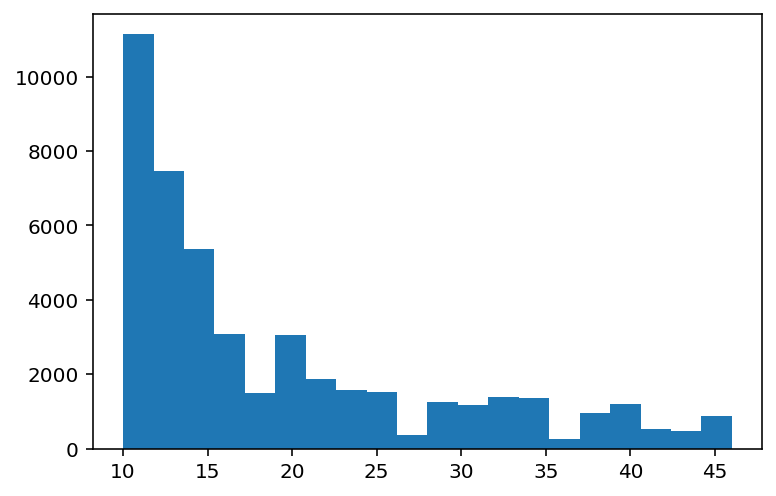

In [65]:
plt.hist(sweep_calls[~numpy.isnan(sweep_calls.clade_mean_dist)].clade_size, bins=20)

In [29]:
sweep_calls.columns

Index(['indiv_1', 'start', 'end', 'called', 'clade_mean_dist', 'clade_size'], dtype='object')

In [30]:
current_sweep_data = pandas.read_hdf('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/male_dist_admix_masked_stores/7/CHB/5e-05/sweep_data_5e-05_50%.hdf')
current_sweep_data.columns

Index(['indiv_1', 'start', 'end', 'mean_dist', 'mean_dist_af',
       'prop_indivs_missing', 'win_swept', 'win_swept_af', 'called',
       'called_af', 'clade_mean_dist', 'clade_mean_dist_af', 'clade_size',
       'clade_size_af', 'run_id', 'run_length', 'swept', 'run_id_af',
       'run_length_af', 'swept_af'],
      dtype='object')

In [78]:
G = nx.Graph()
G.add_nodes_from(range(10), color='red')
G.add_nodes_from(range(10, 20), color='green')
edges = list(itertools.combinations(range(10), 2))
G.add_edges_from(edges)
other_edges = list(itertools.combinations(range(8, 20), 2))
G.add_edges_from(other_edges)
#G.add_edges_from([(1, 50)])
G

In [79]:
G.graph

{}

In [80]:
lst = list(nx.algorithms.clique.find_cliques(G))
print(len(lst))
for g in lst:
    print(g)

2
[8, 9, 0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


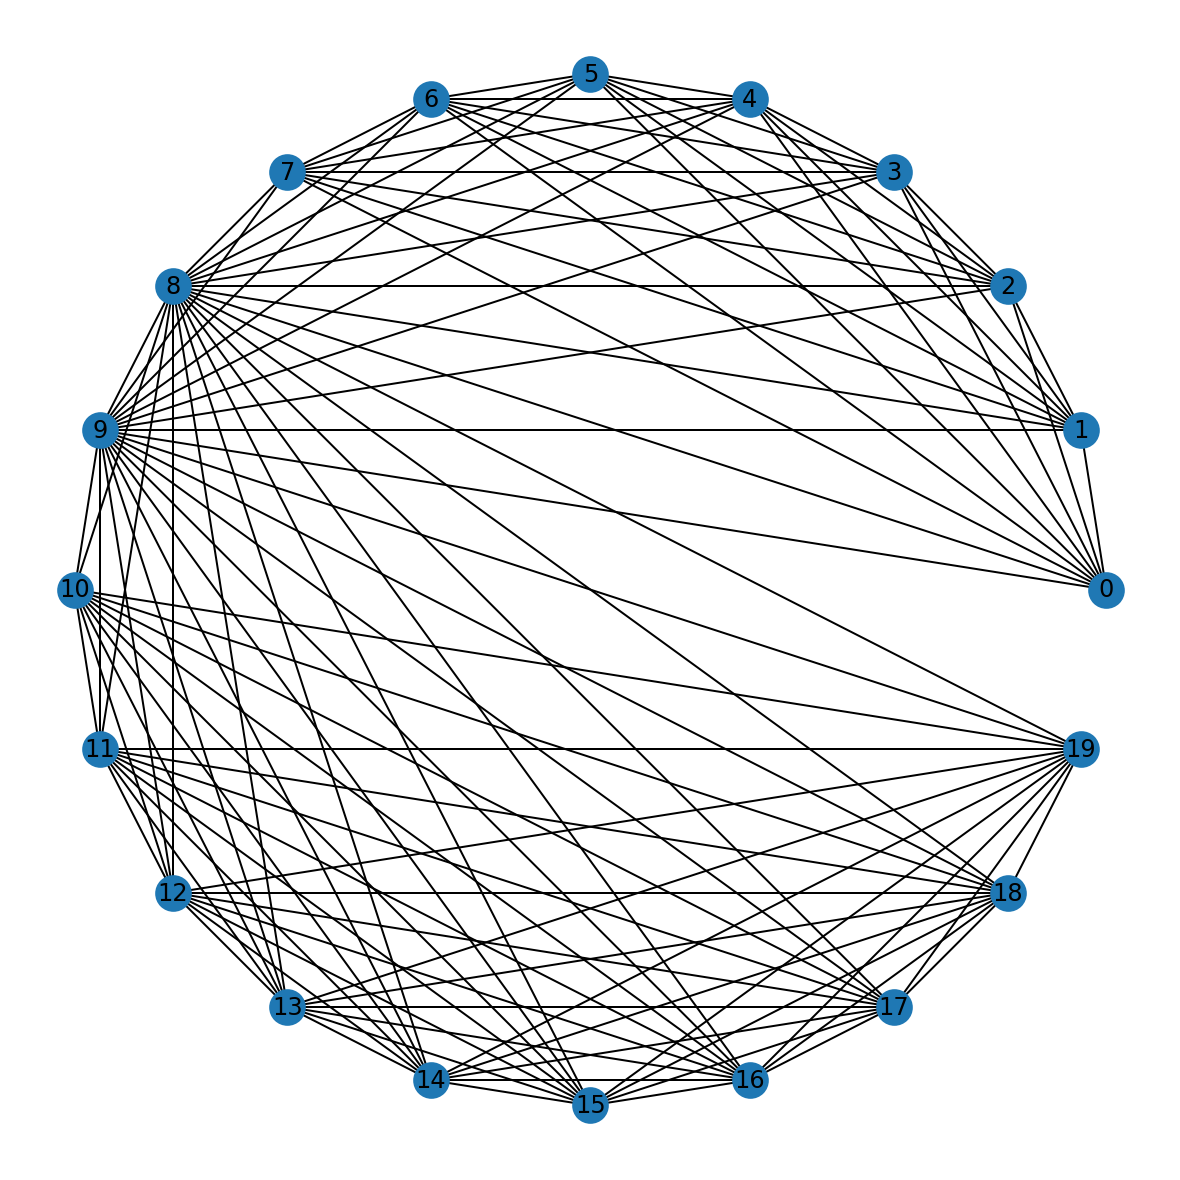

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
nx.draw_shell(G, with_labels=True)
plt.show()

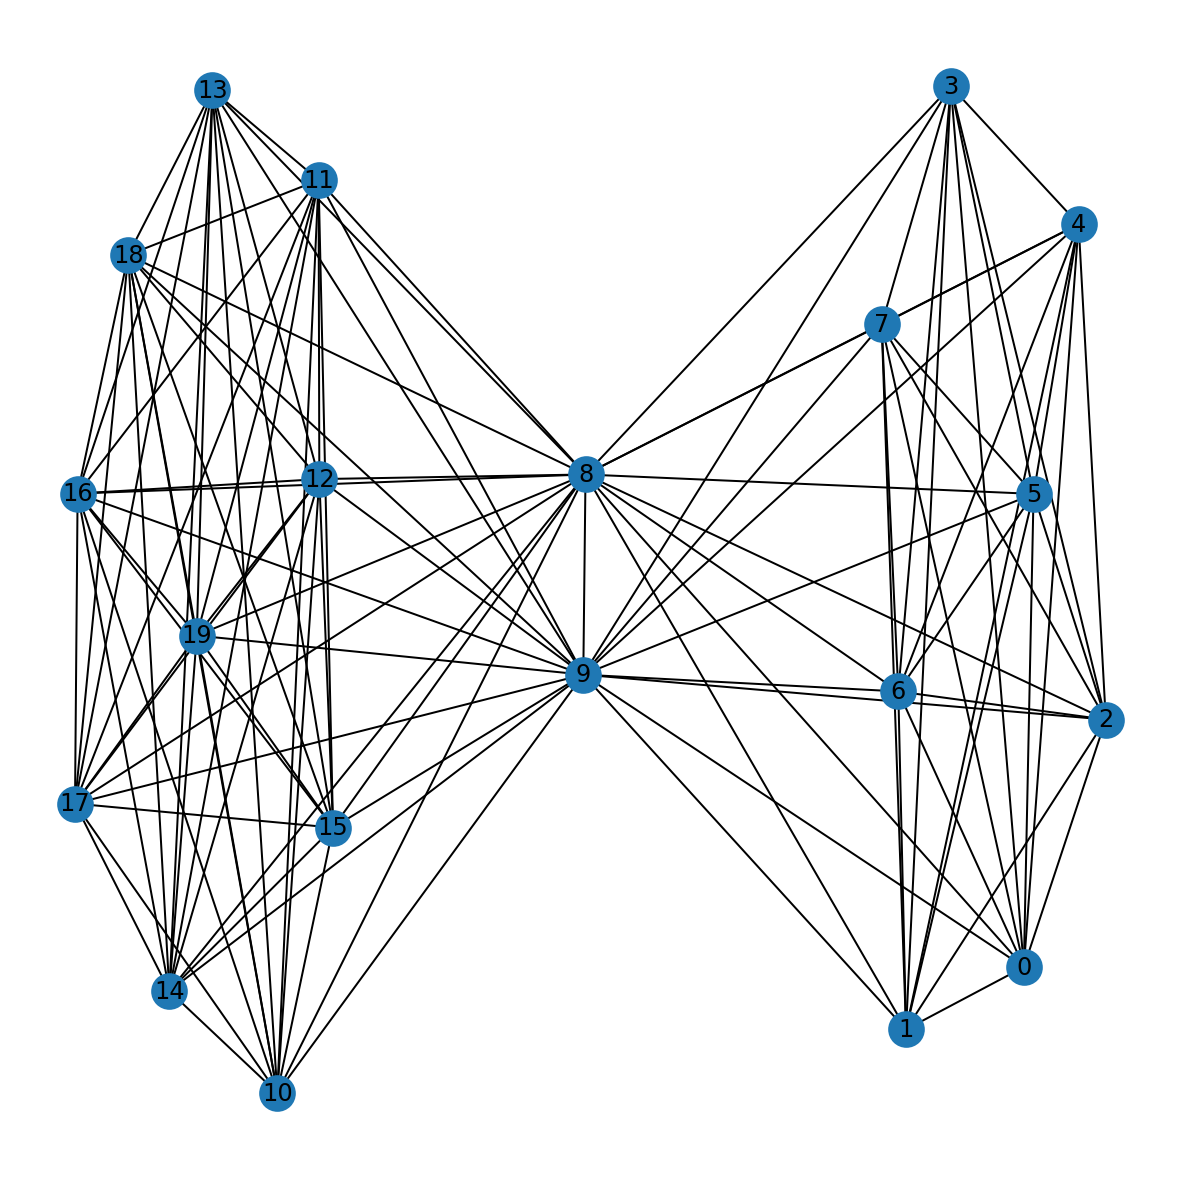

In [82]:
plt.figure(figsize=(8, 8))
nx.draw_spring(G, with_labels=True)
plt.show()

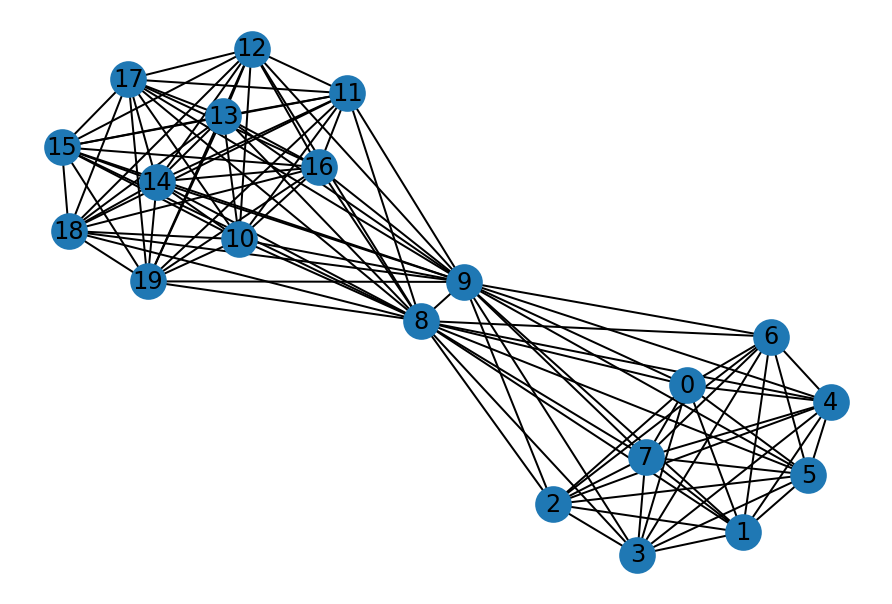

In [83]:
pos=nx.spring_layout(G,iterations=200)
#pos=nx.shell_layout(G)


nx.draw(G,pos,with_labels=True)
for clique in lst:
    if len(clique) > 20:
        nx.draw_networkx_nodes(G, pos, nodelist=clique, node_color='red')

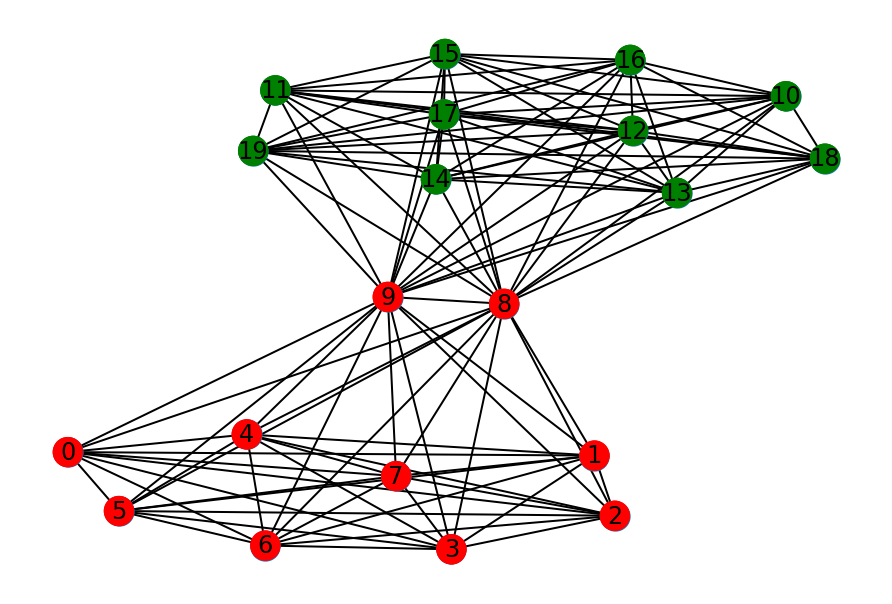

In [84]:
options = {'node_size': 200}

pos=nx.spring_layout(G,iterations=200)
#pos=nx.shell_layout(G)

colors = nx.get_node_attributes(G,'color').values()
nx.draw(G,pos,with_labels=True, **options)
for clique in lst:
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=colors, **options)
        

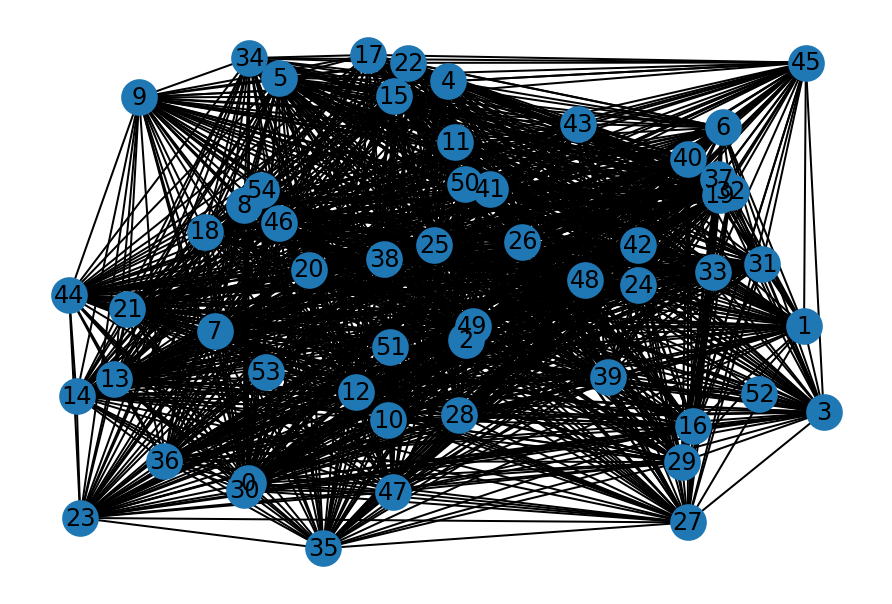

In [29]:
pos=nx.random_layout(G)
nx.draw(G,pos,with_labels=True)


In [30]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(g,'group').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.node[n]['group']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

AttributeError: 'list' object has no attribute 'nodes'